### Tablas y Figuras

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from fkdc.config import clasificadores, grillas, main_seed, _get_run_seeds
from fkdc.tarea import Tarea
from fkdc.datasets import Dataset

import os
import pickle

os.getcwd()
from pathlib import Path

# Los experimentos del 29.10.2024 corrieron con main_seed = 2024
# main_seed = 2024
run_seeds = _get_run_seeds()

root_dir = Path("/Users/gonzalo/Git/fkdc")
data_dir = root_dir / "docs/data"
img_dir = root_dir / "docs/img"
for directory in [data_dir, img_dir]:
    directory.mkdir(exist_ok=True)
run_dir = root_dir / "infos"
datasets_dir = root_dir / "datasets"

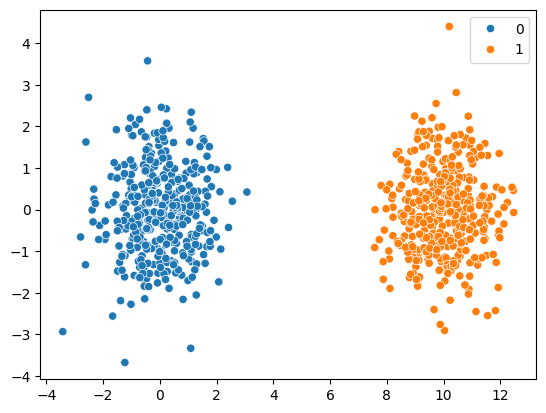

In [2]:
seed = 2024
ds = Dataset.de_fabrica(
    make_blobs,
    n_samples=(400, 400),
    n_features=2,
    centers=((0, 0), (10, 0)),
    random_state=seed,
)
ds.scatter()

In [3]:
run_2blobs = data_dir / f"2blobs-{seed}.pkl"
if run_2blobs.exists():
    tarea = pickle.load(open(run_2blobs, "rb"))
else:
    tarea = Tarea(
        ds,
        {nombre: (clf, grillas[nombre]) for nombre, clf in clasificadores.items()},
        seed=seed,
    )
    tarea.entrenar()
    tarea.evaluar()
    tarea.guardar(run_2blobs)

In [4]:
campos = {"logvero": "$cal(l)$", "r2": "$R^2$", "accuracy": "exac"}
tabla = pd.DataFrame(tarea.info).T[campos.keys()].rename(columns=campos).astype(float)
tabla.index = "#" + tabla.index
tabla

,$cal(l)$,$R^2$,exac
#fkdc,-3.552714e-14,1.000000,1.0
#kdc,-3.552714e-14,1.000000,1.0
#gnb,-2.513867e-11,1.000000,1.0
#kn,-3.552714e-14,1.000000,1.0
#fkn,-3.552714e-14,1.000000,1.0
#lr,-4.545291e+00,0.959016,1.0
#svc,NaN,NaN,1.0
#lsvc,NaN,NaN,1.0
#base,-1.109035e+02,0.000000,0.5


In [5]:
tabla.round(4).to_csv(data_dir / "2-blobs.csv")

In [6]:
run_seeds[0]

1706

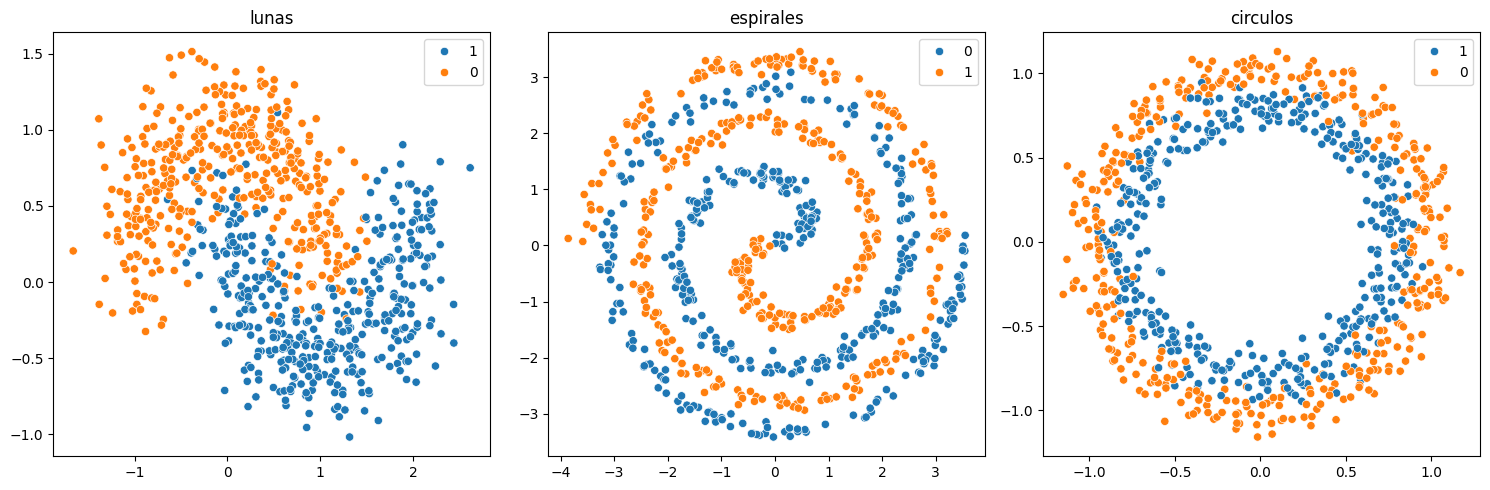

In [7]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = run_seeds[0]
datasets_2d = ["lunas", "espirales", "circulos"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(datasets_dir / f"{nombre}_lo-{seed}.pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales.svg")

In [8]:
eval("'asd'")

'asd'

In [9]:
def load_infos(dir=run_dir):
    return {
        tuple(fn.stem.split("-")): pickle.load(open(fn, "rb"))
        for fn in Path(dir).glob("*.pkl")
    }


infos = load_infos()

In [10]:
this_infos = {
    k: v
    for k, v in infos.items()
    if k[4] == "accuracy" and any(f"{ds}_lo" == k[0] for ds in datasets_2d)
}

In [11]:
list(this_infos.keys())[:4]

[('espirales_lo', '8195', 'fkdc', '2024', 'accuracy'),
 ('espirales_lo', '1706', 'gnb', '2024', 'accuracy'),
 ('lunas_lo', '3858', 'lsvc', '2024', 'accuracy'),
 ('espirales_lo', '9238', 'svc', '2024', 'accuracy')]

In [12]:
def pluck(D, filter):
    if callable(filter):
        return {k: v for k, v in D.items() if filter(k)}
    elif isinstance(filter, (list, tuple)):
        return {k: v for k, v in D.items() if k in filter}

In [13]:
import numpy as np


basic_fields = ["accuracy", "r2", "logvero"]
basic_infos = {}
for k, v in infos.items():
    clf = k[2]
    basic_infos[k] = {k: v for k, v in v[clf].items() if k in basic_fields}
    if clf == "fkdc":
        basic_infos[(k[0], k[1], "base", k[3], k[4])] = {
            k: v for k, v in v["base"].items() if k in basic_fields
        }

basic_info = pd.DataFrame.from_records(
    list(basic_infos.values()),
    index=pd.MultiIndex.from_tuples(
        basic_infos.keys(), names=["dataset", "ds_seed", "clf", "run_seed", "score"]
    ),
).reset_index()
assert all((basic_info.ds_seed == "None") | (basic_info.run_seed == "2024"))
basic_info["semilla"] = np.where(
    basic_info.ds_seed == "None", basic_info.run_seed, basic_info.ds_seed
).astype(int)
bi = basic_info = basic_info.drop(columns=["ds_seed", "run_seed"])
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   5120 non-null   object 
 1   clf       5120 non-null   object 
 2   score     5120 non-null   object 
 3   logvero   4480 non-null   float64
 4   r2        4480 non-null   float64
 5   accuracy  5120 non-null   float64
 6   semilla   5120 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 280.1+ KB


In [14]:
bi[(bi.score == "accuracy") & bi.dataset.str.endswith("_lo")]

,dataset,clf,score,logvero,r2,accuracy,semilla
2,espirales_lo,fkdc,accuracy,-31.660030,0.886033,0.9900,8195
3,espirales_lo,base,accuracy,-277.799061,0.000000,0.4850,8195
5,espirales_lo,gnb,accuracy,-270.048550,0.027900,0.5250,1706
8,lunas_lo,lsvc,accuracy,NaN,NaN,0.8675,3858
22,espirales_lo,svc,accuracy,NaN,NaN,0.9875,9238
...,...,...,...,...,...,...,...
5031,circulos_lo,svc,accuracy,NaN,NaN,0.9025,8811
5054,lunas_lo,svc,accuracy,NaN,NaN,0.9350,3785
5082,espirales_lo,kdc,accuracy,-274.897760,0.010444,0.9525,2493
5092,circulos_lo,fkn,accuracy,-524.679771,-0.887377,0.8800,9962


In [15]:
exacs = bi[(bi.score == "accuracy") & bi.dataset.str.endswith("_lo")][
    ["dataset", "clf", "accuracy"]
]
exacs["dataset"] = exacs.dataset.str.rstrip("_lo")
exacs = exacs.rename(columns={"accuracy": "exac"})

In [16]:
exacs.groupby(["clf", "dataset"]).exac.median().reset_index().pivot(
    index="clf", columns="dataset", values="exac"
).round(3)

dataset,circulos,espirales,lunas
clf,,,
base,0.492,0.485,0.492
fkdc,0.864,0.981,0.939
fkn,0.859,0.982,0.938
gnb,0.754,0.498,0.855
kdc,0.872,0.982,0.936
kn,0.859,0.982,0.938
lr,0.494,0.519,0.858
lsvc,0.481,0.501,0.856
svc,0.890,0.980,0.935


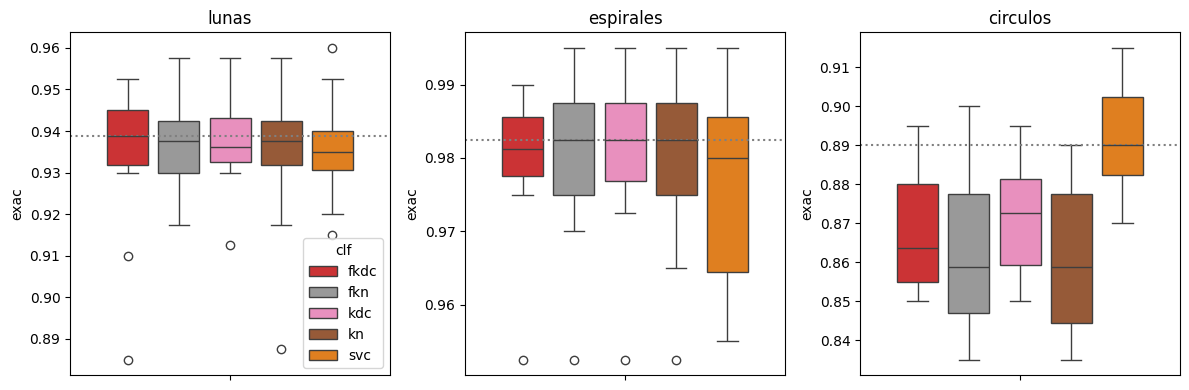

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
seed = 4107
colors = dict(zip(exacs.clf.unique(), sns.color_palette("Set1")))
exclude_clfs = ["base", "gnb", "lr", "lsvc"]
# exclude_clfs = ["base"]
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = exacs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="exac", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").exac.median().max(), linestyle="dotted", color="gray"
    )
    # ax.set_ylim(0.8, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-new.svg")

In [18]:
loc_measure = "mean"
tabla = (
    exacs.groupby(["dataset", "clf"])
    .exac.agg([loc_measure, "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=[loc_measure, "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])
tabla = tabla.apply(lambda x: round(100 * x, 2))[tabla.columns.sortlevel()[0]].round(2)
tabla.to_csv(data_dir / "exac-ds-2d-new.csv")
tabla

dataset circulos       espirales        lunas      
            mean   std      mean   std   mean   std
clf                                                
base       49.00  0.90     48.50  0.00  49.00  0.90
fkdc       86.78  1.53     98.06  0.91  93.45  1.66
fkn        86.30  1.91     98.06  1.03  93.66  1.08
gnb        75.77  6.05     50.03  2.10  85.53  1.35
kdc        87.22  1.49     98.09  1.00  93.80  1.01
kn         86.11  1.77     98.03  1.08  93.48  1.60
lr         49.70  2.19     51.73  2.36  85.59  1.30
lsvc       49.28  3.28     50.16  1.45  85.30  1.53
svc        89.20  1.19     97.70  1.31  93.52  1.18

In [19]:
rsqs = bi[(bi.score == "accuracy") & bi.dataset.str.endswith("_lo")][
    ["dataset", "clf", "r2"]
].dropna()
rsqs["dataset"] = rsqs.dataset.str.rstrip("_lo")

In [20]:
rsqs.groupby(["dataset", "clf"]).r2.mean().reset_index().pivot(
    index="clf", columns="dataset", values="r2"
).round(3)

dataset,circulos,espirales,lunas
clf,,,
base,0.000,0.000,0.000
fkdc,0.459,0.666,0.586
fkn,-0.502,0.259,0.441
gnb,0.064,0.008,0.526
kdc,0.517,0.800,0.731
kn,-0.428,0.123,0.091
lr,-0.002,0.010,0.533


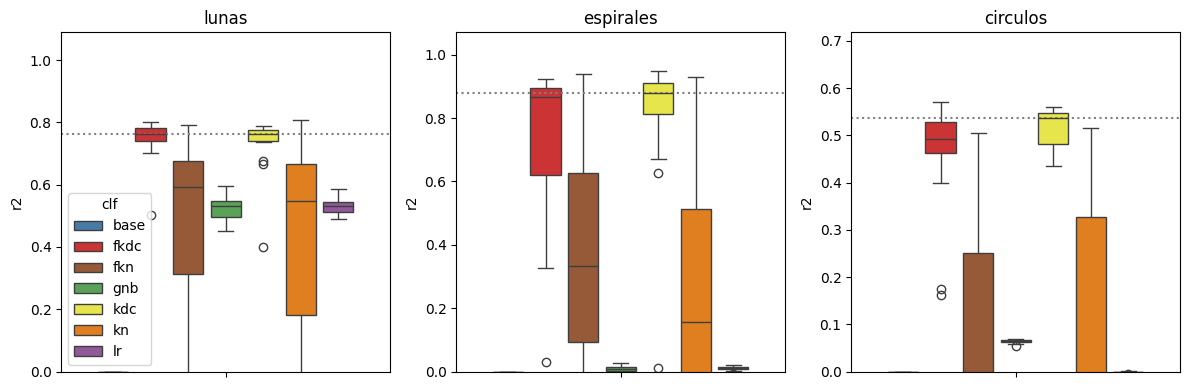

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

colors = dict(zip(rsqs.clf.unique(), sns.color_palette("Set1")))
# exclude_clfs = ["base", "gnb", "lr", "lsvc"]
exclude_clfs = []
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = rsqs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray")
    ax.set_ylim(0, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-r2-lunas-espirales-circulos-new.svg")

In [22]:
loc_measure = "median"
tabla = (
    rsqs.groupby(["dataset", "clf"])
    .r2.agg([loc_measure, "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=[loc_measure, "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [23]:
tabla = tabla[tabla.columns.sortlevel()[0]].round(3).dropna()
tabla.to_csv(data_dir / "r2-ds-2d-new.csv")
tabla

dataset circulos        espirales         lunas       
          median    std    median    std median    std
clf                                                   
base       0.000  0.000     0.000  0.000  0.000  0.000
fkdc       0.493  0.122     0.868  0.364  0.764  0.655
fkn       -0.146  0.862     0.334  0.564  0.593  0.402
gnb        0.064  0.004     0.007  0.010  0.532  0.040
kdc        0.537  0.041     0.878  0.231  0.763  0.096
kn        -0.134  0.907     0.157  0.591  0.547  1.375
lr        -0.001  0.003     0.011  0.006  0.531  0.028

In [24]:
infos.keys()

dict_keys([('circulos_lo', '2280', 'fkn', '2024', 'neg_log_loss'), ('eslabones_0', '2928', 'kdc', '2024', 'accuracy'), ('espirales_lo', '8195', 'fkdc', '2024', 'accuracy'), ('hueveras_12', '3173', 'gnb', '2024', 'neg_log_loss'), ('espirales_lo', '1706', 'gnb', '2024', 'accuracy'), ('lunas_hi', '9962', 'lsvc', '2024', 'accuracy'), ('vino', 'None', 'gnb', '2280', 'neg_log_loss'), ('lunas_lo', '3858', 'lsvc', '2024', 'accuracy'), ('pionono_0', '2928', 'svc', '2024', 'accuracy'), ('hueveras_0', '9962', 'gnb', '2024', 'neg_log_loss'), ('pinguinos', 'None', 'fkdc', '3173', 'accuracy'), ('lunas_hi', '7082', 'lsvc', '2024', 'accuracy'), ('pinguinos', 'None', 'fkdc', '1831', 'neg_log_loss'), ('iris', 'None', 'kdc', '3173', 'neg_log_loss'), ('eslabones_0', '3173', 'gnb', '2024', 'accuracy'), ('helices_12', '1706', 'kn', '2024', 'accuracy'), ('pinguinos', 'None', 'fkn', '9178', 'neg_log_loss'), ('pinguinos', 'None', 'kdc', '1831', 'accuracy'), ('digitos', 'None', 'kn', '3785', 'accuracy'), ('espi

In [25]:
run_seeds

[1706,
 1708,
 1831,
 2280,
 2493,
 2627,
 2928,
 3173,
 3785,
 3858,
 7082,
 8195,
 8811,
 9178,
 9238,
 9962]

In [26]:
corrida = lambda x: ("circulos_lo", str(run_seeds[2]), x, str(main_seed), "accuracy")
clfs = ["kcd", "fkdc"]
df = pd.concat(
    {
        clf: pd.DataFrame(infos[corrida(clf)][clf].busqueda.cv_results_)
        for clf in ("kdc", "fkdc")
    },
    names=["est", "index"],
).reset_index()

In [27]:
coso = df.query("est == 'kdc'").param_alpha.unique()[0]

In [28]:
df.groupby("est").param_alpha.agg(lambda x: x.isna().mean())

est
fkdc    0.0
kdc     1.0
Name: param_alpha, dtype: float64

In [29]:
df[df.param_alpha.isna() | (df.param_alpha == 1)].groupby(
    ["est", "param_alpha"], dropna=False
).size()

est   param_alpha
fkdc  1.0             21
kdc   NaN            101
dtype: int64

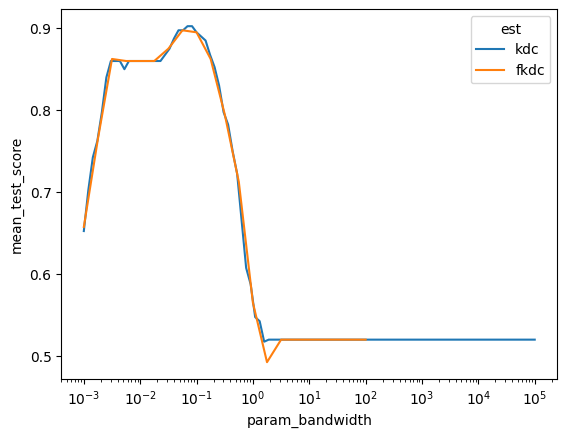

In [30]:
sns.lineplot(
    df[(df.est == "kdc") | ((df.est == "fkdc") & (df.param_alpha == 1))],
    y="mean_test_score",
    x="param_bandwidth",
    hue="est",
)
plt.xscale("log")

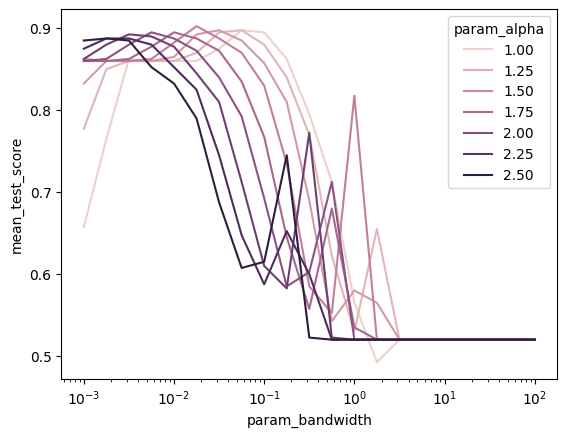

In [31]:
sns.lineplot(
    df[(df.est == "fkdc")],
    y="mean_test_score",
    x="param_bandwidth",
    hue="param_alpha",
)
plt.xscale("log")

In [32]:
data = df[(df.est == "fkdc")].pivot(
    index="param_alpha", columns="param_bandwidth", values="mean_test_score"
)
X = data.columns.values
Y = data.index.values
Z = data.values

In [33]:
df[df.rank_test_score == 1].filter(like="param_")

,param_bandwidth,param_alpha
23,0.069183,NaN
24,0.083176,NaN
169,0.017783,1.5625


In [34]:
infos[corrida("fkdc")].fkdc.busqueda.best_params_

{'alpha': 1.5625, 'bandwidth': 0.01778279410038923}

In [35]:
import json
import numpy as np


class NumpyEncoder(json.JSONEncoder):
    """Special json encoder for numpy types"""

    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [36]:
data = {
    "corrida": corrida("")[:2],
    "best_params": {
        clf: infos[corrida(clf)][clf].busqueda.best_params_
        for clf in clasificadores.keys()
    },
    "exac": {clf: infos[corrida(clf)][clf].accuracy for clf in clasificadores.keys()},
}

In [37]:
data

{'corrida': ('circulos_lo', '1831'),
 'best_params': {'fkdc': {'alpha': 1.5625, 'bandwidth': 0.01778279410038923},
  'kdc': {'bandwidth': 0.06918309709189366},
  'gnb': {'var_smoothing': 0.01},
  'kn': {'n_neighbors': 3, 'weights': 'uniform'},
  'fkn': {'alpha': 1.5, 'n_neighbors': 5, 'weights': 'uniform'},
  'lr': {'C': 0.01, 'l1_ratio': 0},
  'svc': {'C': 0.5248074602497729, 'gamma': 'scale'},
  'lsvc': {'C': 0.001, 'fit_intercept': True}},
 'exac': {'fkdc': 0.85,
  'kdc': 0.8575,
  'gnb': 0.74,
  'kn': 0.8375,
  'fkn': 0.8575,
  'lr': 0.48,
  'svc': 0.87,
  'lsvc': 0.4625}}

In [38]:
dumped = json.dumps(data, cls=NumpyEncoder)

with open(data_dir / f"best_params-2d-lo-new.json", "w") as f:
    json.dump(dumped, f)

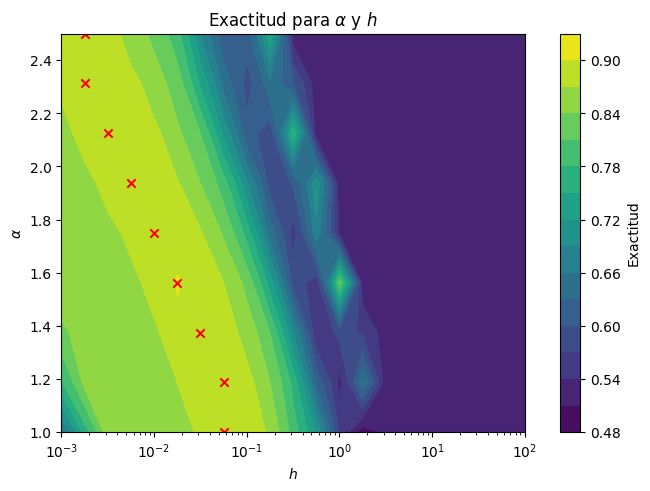

In [39]:
from matplotlib import colors

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

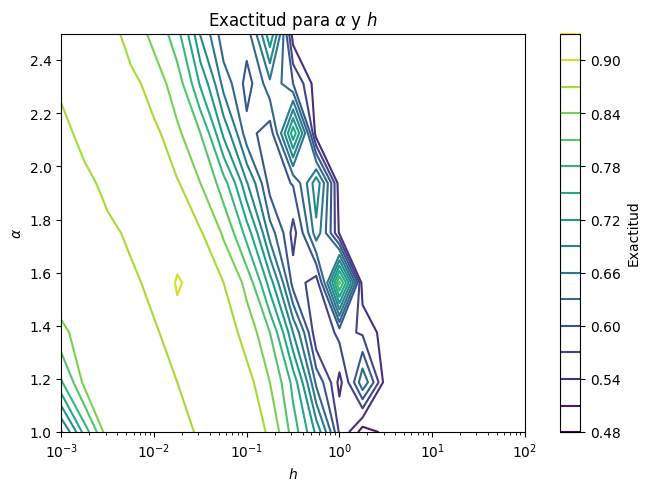

In [40]:
from matplotlib import colors

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
plt.xscale("log")

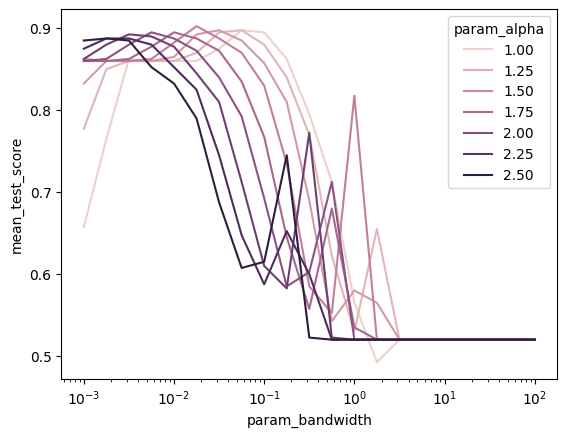

In [41]:
sns.lineplot(
    df[(df.est == "fkdc")],
    y="mean_test_score",
    x="param_bandwidth",
    hue="param_alpha",
)
plt.xscale("log")

In [42]:
some_seeds = np.random.choice(run_seeds, 3)

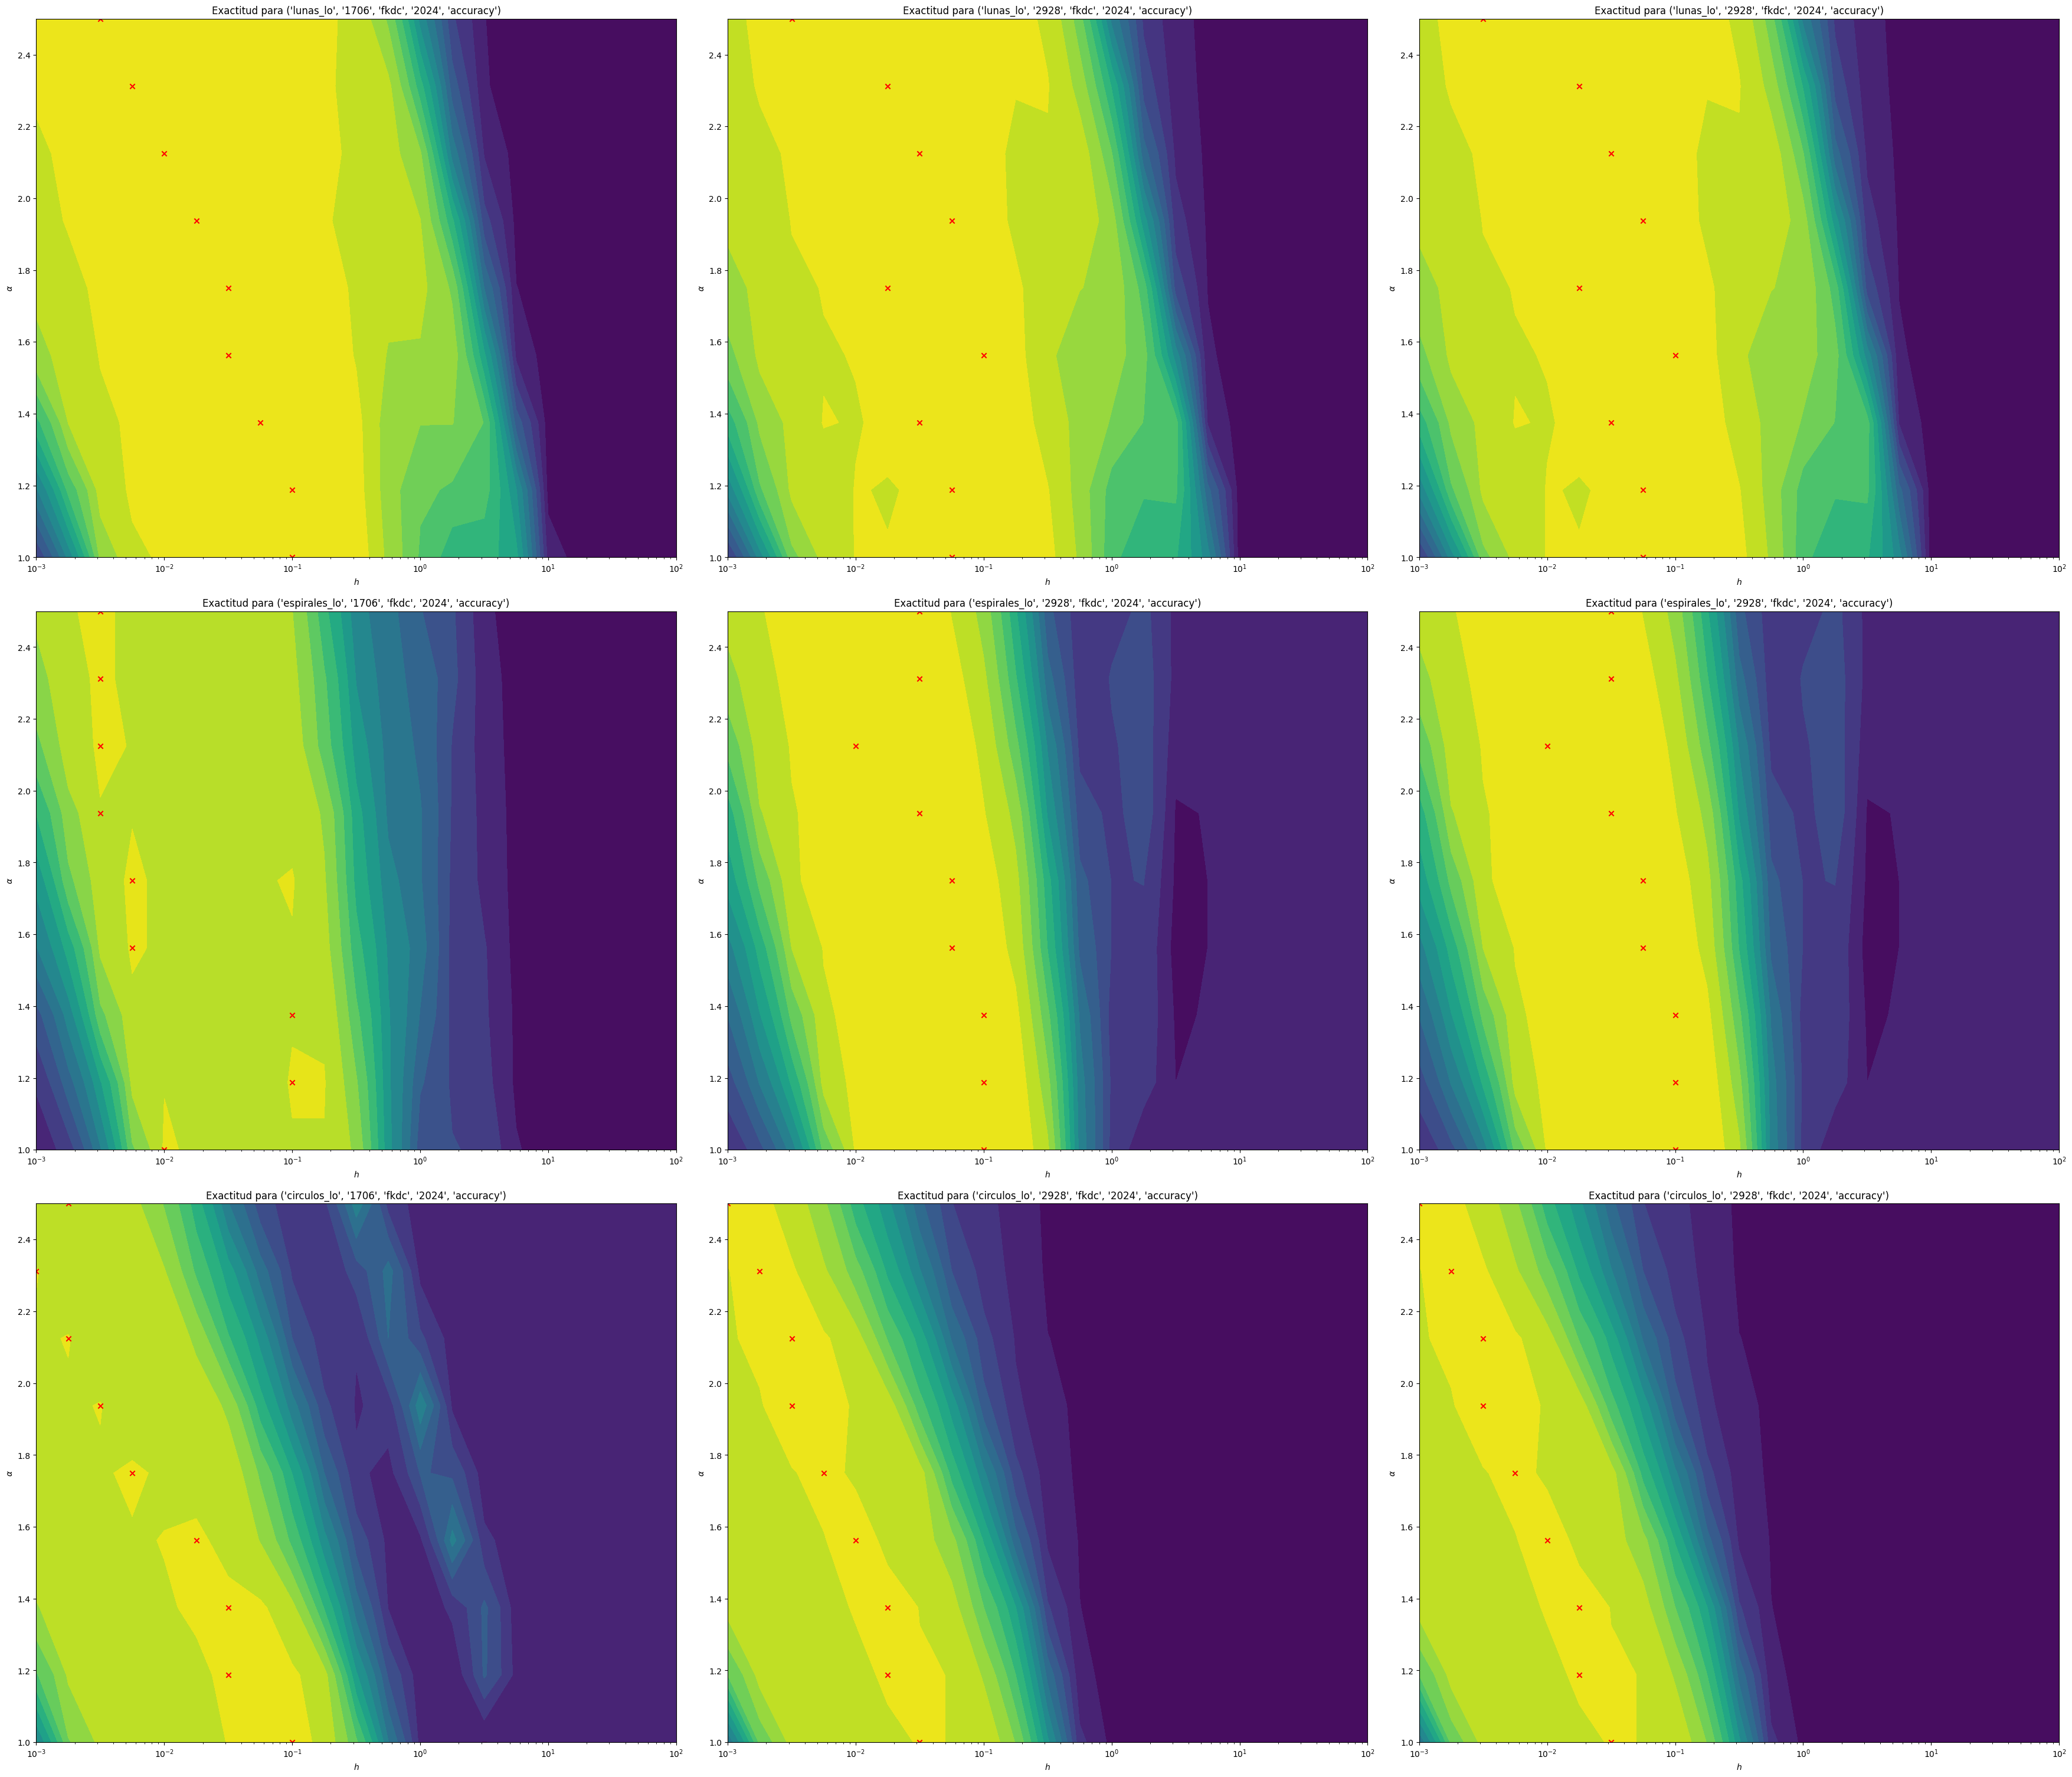

In [43]:
from matplotlib import colors
from itertools import product

fig, axs = plt.subplots(3, 3, figsize=(35, 30), layout="constrained")
for (ds, seed), ax in zip(product(datasets_2d, some_seeds), axs.flatten()):
    key = (ds + "_lo", str(seed), "fkdc", str(main_seed), "accuracy")
    df = pd.DataFrame(infos[key]["fkdc"].busqueda.cv_results_)
    data = df.pivot(
        index="param_alpha", columns="param_bandwidth", values="mean_test_score"
    )
    X = data.columns.values
    Y = data.index.values
    Z = data.values
    zmin, zmax = Z.min(), Z.max()
    CS = ax.contourf(X, Y, Z**2, 15, cmap="viridis")
    ax.set_title(f"Exactitud para {key}")
    ax.set_xlabel("$h$")
    ax.set_ylabel("$\\alpha$")
    ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
    # Make a colorbar for the ContourSet returned by the contourf call.
    # cbar = fig.colorbar(CS)
    # cbar.ax.set_ylabel("Exactitud")
    ax.set_xscale("log")
    # plt.tight_layout()
fig.savefig(img_dir / "many-heatmaps-fkdc-2d-lo-new.svg")

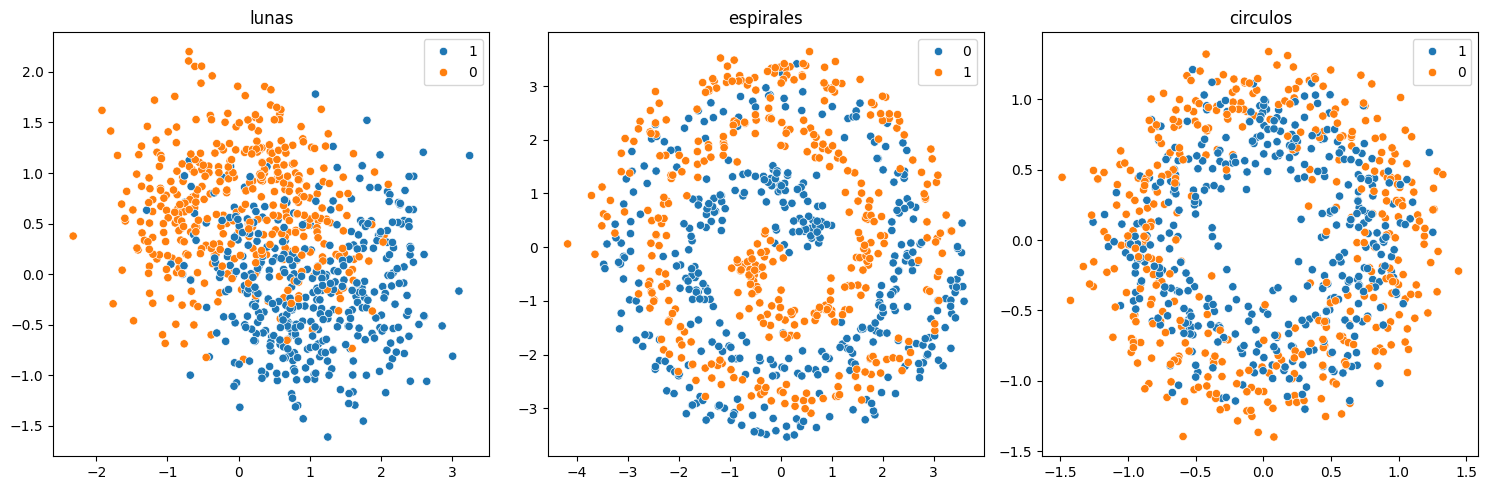

In [44]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = run_seeds[0]
datasets_2d = ["lunas", "espirales", "circulos"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(datasets_dir / f"{nombre}_hi-{seed}.pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales-hi-new.svg")

In [137]:
infos = {
    (nombre, seed): pickle.load(
        open(run_dir / f"info-('{nombre}', {seed}, 'hi').pkl", "rb")
    )
    for seed in run_seeds
    for nombre in datasets_2d
}

In [62]:
exacs = bi[(bi.score == "neg_log_loss") & bi.dataset.str.endswith("_hi")][
    ["dataset", "clf", "accuracy"]
]
exacs["dataset"] = exacs.dataset.str.rstrip("_hi")
exacs = exacs.rename(columns={"accuracy": "exac"})
exacs

,dataset,clf,exac
31,circulos,kn,0.6575
35,espirales,fkn,0.8075
57,lunas,gnb,0.7825
74,lunas,lr,0.8150
99,espirales,lr,0.5275
...,...,...,...
5044,circulos,fkdc,0.6675
5045,circulos,base,0.4725
5057,lunas,gnb,0.7975
5058,lunas,kn,0.7675


In [63]:
exacs.groupby(["clf", "dataset"]).exac.median().reset_index().pivot(
    index="clf", columns="dataset", values="exac"
).round(3)

dataset,circulos,espirales,lunas
clf,,,
base,0.492,0.485,0.492
fkdc,0.671,0.839,0.816
fkn,0.659,0.832,0.809
gnb,0.652,0.500,0.798
kdc,0.679,0.850,0.816
kn,0.660,0.824,0.815
lr,0.492,0.505,0.806


In [64]:
datasets_2d

['lunas', 'espirales', 'circulos']

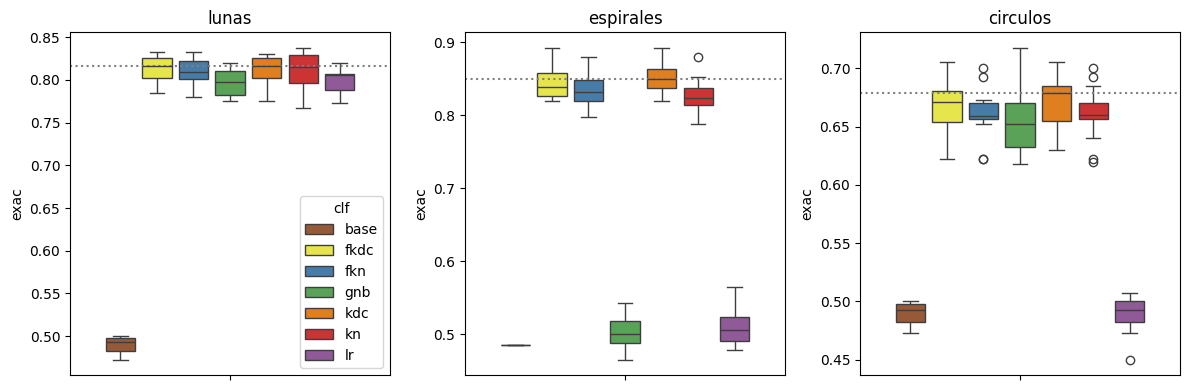

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = dict(zip(exacs.clf.unique(), sns.color_palette("Set1")))
# exclude_clfs = ["base", "gnb", "lr", "lsvc"]
exclude_clfs = []
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = exacs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="exac", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").exac.median().max(), linestyle="dotted", color="gray"
    )
    # ax.set_ylim(0.8, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-hi-new.svg")

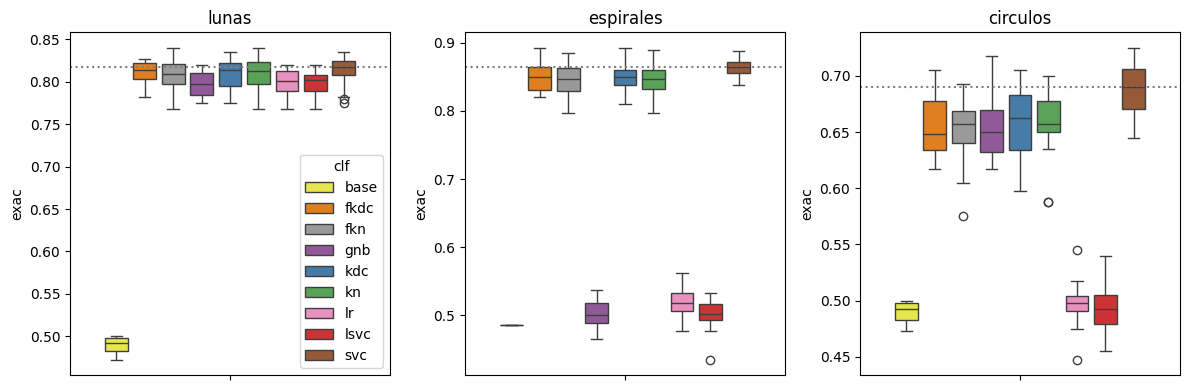

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = dict(zip(exacs.clf.unique(), sns.color_palette("Set1")))
# exclude_clfs = ["base", "gnb", "lr", "lsvc"]
exclude_clfs = []
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = exacs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="exac", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").exac.median().max(), linestyle="dotted", color="gray"
    )
    # ax.set_ylim(0.8, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-hi-new.svg")

In [52]:
tabla = (
    exacs.groupby(["dataset", "clf"])
    .exac.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [54]:
tabla = tabla.apply(lambda x: round(100 * x, 2))[tabla.columns.sortlevel()[0]].round(2)
tabla.to_csv(data_dir / "exac-ds-2d-hi-new.csv")
tabla

dataset circulos        espirales          lunas       
            mean    std      mean    std    mean    std
clf                                                    
base      4900.0   90.0    4850.0    0.0  4900.0   90.0
fkdc      6541.0  271.0    8489.0  214.0  8102.0  146.0
fkn       6508.0  305.0    8445.0  245.0  8088.0  194.0
gnb       6552.0  288.0    5005.0  203.0  7983.0  151.0
kdc       6586.0  308.0    8480.0  211.0  8091.0  191.0
kn        6572.0  327.0    8459.0  230.0  8100.0  205.0
lr        4967.0  210.0    5184.0  241.0  8002.0  160.0
lsvc      4936.0  216.0    5011.0  233.0  7983.0  143.0
svc       6878.0  250.0    8638.0  144.0  8122.0  183.0

In [69]:
rsqs = bi[(bi.score == "neg_log_loss") & bi.dataset.str.endswith("_hi")][
    ["dataset", "clf", "r2"]
].dropna()
rsqs["dataset"] = rsqs.dataset.str.rstrip("_hi")

In [70]:
rsqs.groupby(["dataset", "clf"]).r2.mean().reset_index().pivot(
    index="clf", columns="dataset", values="r2"
).round(3)

dataset,circulos,espirales,lunas
clf,,,
base,0.000,0.000,0.000
fkdc,0.114,0.475,0.398
fkn,0.092,0.361,0.328
gnb,0.052,0.008,0.373
kdc,0.112,0.498,0.400
kn,0.094,0.418,0.367
lr,-0.001,0.010,0.376


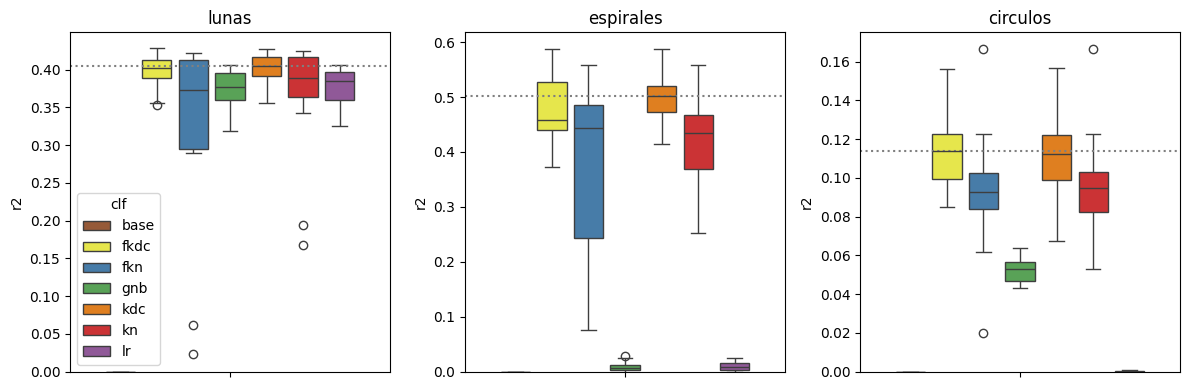

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = dict(zip(rsqs.clf.unique(), sns.color_palette("Set1")))
# exclude_clfs = ["base", "gnb", "lr", "lsvc"]
exclude_clfs = []
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = rsqs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray")
    ax.set_ylim(0, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-hi-new.svg")

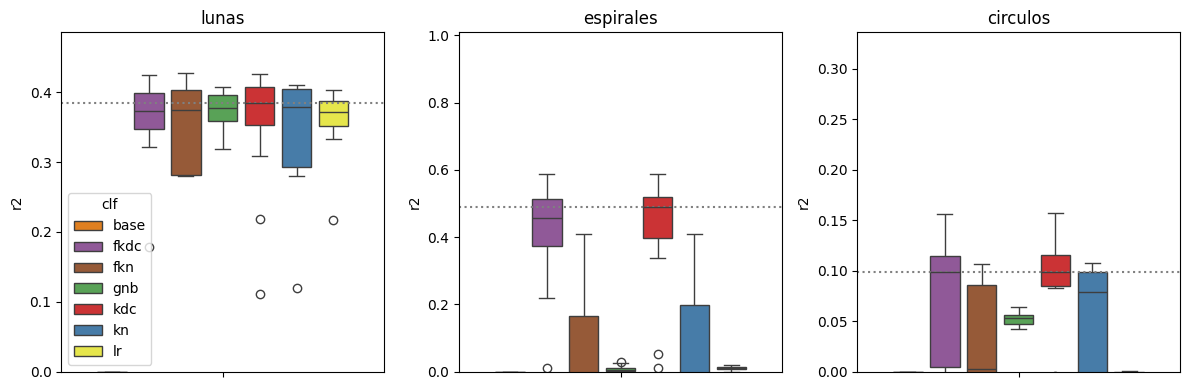

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = dict(zip(rsqs.clf.unique(), sns.color_palette("Set1")))
# exclude_clfs = ["base", "gnb", "lr", "lsvc"]
exclude_clfs = []
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = rsqs.query("dataset == @nombre and clf not in @exclude_clfs").sort_values(
        "clf"
    )
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray")
    ax.set_ylim(0, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-hi-new.svg")

In [60]:
tabla = (
    rsqs.groupby(["dataset", "clf"])
    .r2.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [61]:
tabla = tabla[tabla.columns.sortlevel()[0]].round(3).dropna()
tabla.to_csv(data_dir / "r2-ds-2d.csv")
tabla

dataset circulos        espirales         lunas       
            mean    std      mean    std   mean    std
clf                                                   
base       0.000  0.000     0.000  0.000  0.000  0.000
fkdc      -0.051  0.380     0.421  0.143  0.335  0.138
fkn       -0.511  1.105    -0.734  1.123  0.203  0.370
gnb        0.052  0.007     0.008  0.010  0.372  0.030
kdc        0.063  0.104    -0.089  2.072  0.359  0.084
kn        -0.307  0.973    -0.551  0.922  0.303  0.210
lr        -0.004  0.006     0.010  0.005  0.363  0.044

In [81]:
bi.query("dataset == 'pionono_0'").groupby(["clf", "score"])[
    ["accuracy", "r2"]
].mean().reset_index().pivot(
    index=["clf"], columns=["score"], values=["accuracy", "r2"]
)

accuracy                     r2             
score  accuracy neg_log_loss  accuracy neg_log_loss
clf                                                
base   0.230000     0.230000  0.000000     0.000000
fkdc   0.927656     0.927344  0.754522     0.823113
fkn    0.924219     0.909375  0.267587     0.688427
gnb    0.748750     0.748750  0.605014     0.604896
kdc    0.926094     0.927813  0.782150     0.822236
kn     0.925000     0.907656 -0.023194     0.687035
lr     0.645781     0.644687  0.419664     0.469552
lsvc   0.644219          NaN       NaN          NaN
svc    0.933594          NaN       NaN          NaN

<Axes: xlabel='neg_log_loss', ylabel='accuracy'>

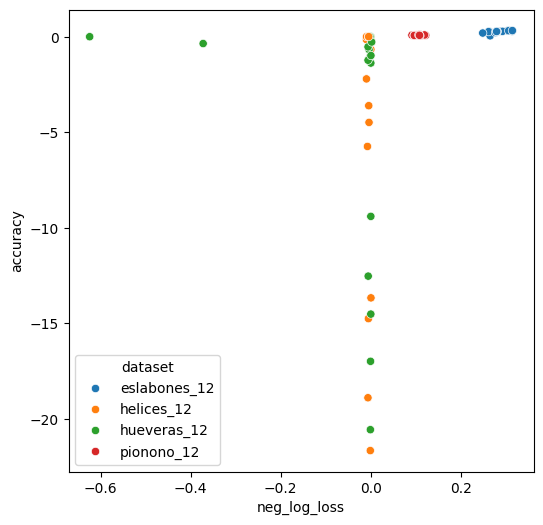

In [143]:
fig, ax = plt.subplots(figsize=(6, 6))
data = (
    bi[(bi.clf == "fkdc") & (bi.dataset.str.endswith("_12"))]
    .pivot(index=["clf", "semilla", "dataset"], columns="score", values="r2")
    .reset_index()
)
sns.scatterplot(
    x="neg_log_loss",
    y="accuracy",
    hue="dataset",
    data=data,
    ax=ax
)
# plt.xlim(0.775, None)
# plt.ylim(0.775, None)
# ax.axline([data.r2.mean()] * 2, slope=1, linestyle="dashed", color="gray")
# ax.get_legend().set_visible(False)

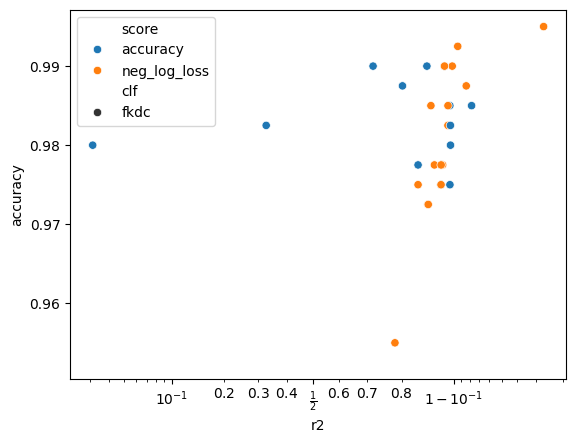

In [91]:
sns.scatterplot(
    x="r2",
    y="accuracy",
    hue="score",
    style="clf",
    data=bi[(bi.dataset == "espirales_lo") & (bi.clf == "fkdc")],
)
# plt.yscale("sqrt")
plt.xscale("logit")

## Tomados de otros notebooks

### Decision Boundary Display

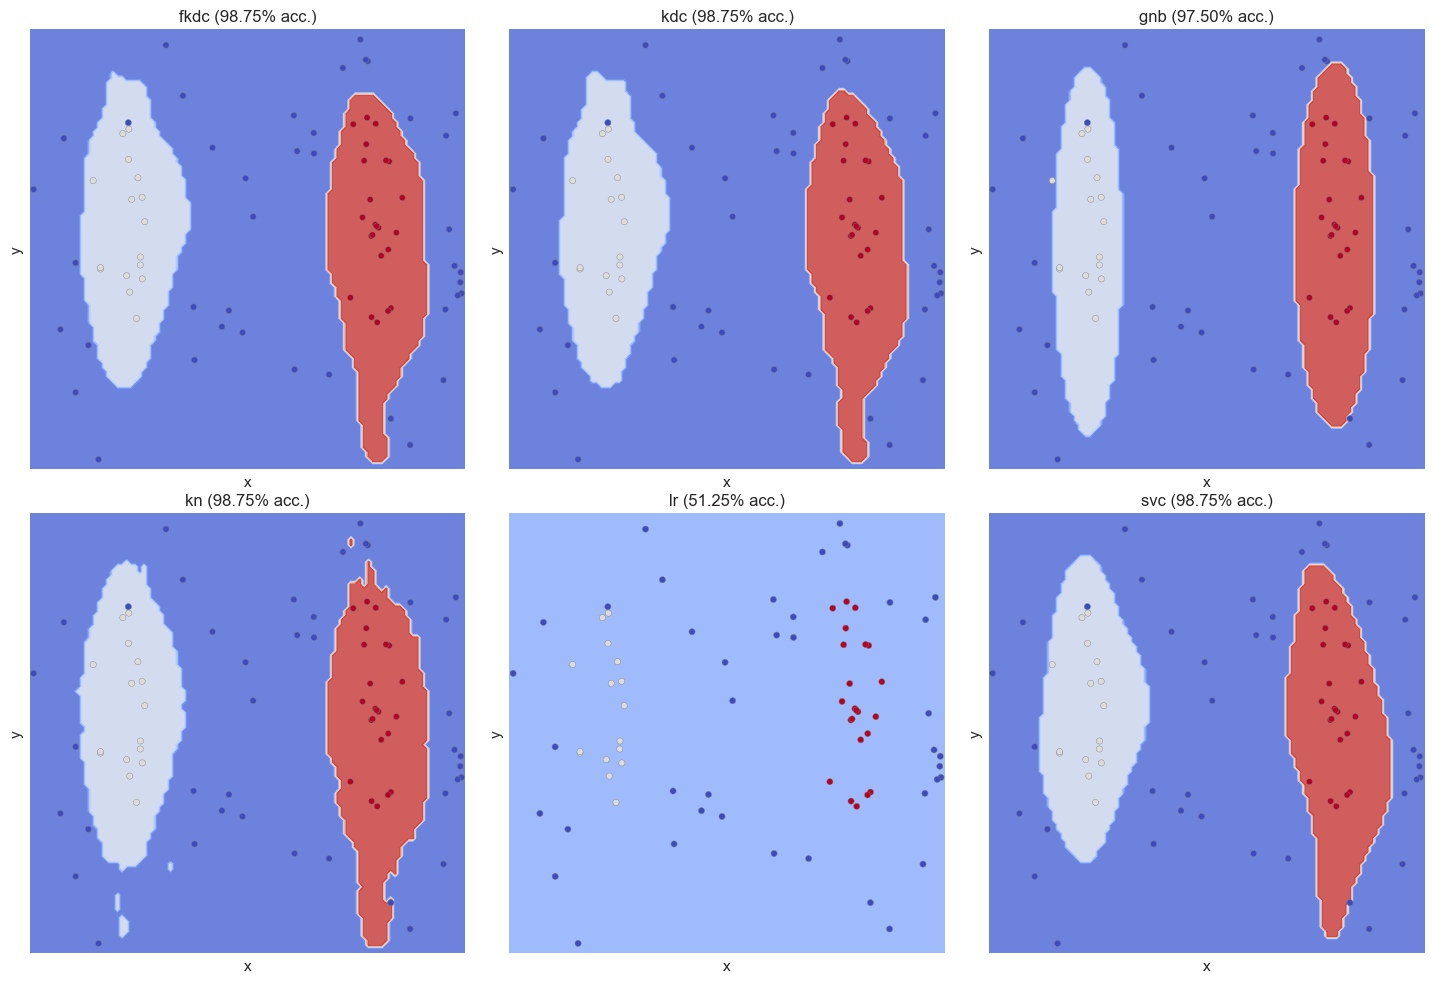

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# Set-up 2x2 grid for plotting.
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

X = tarea.X_eval
y = tarea.y_eval
X0, X1 = X[:, 0], X[:, 1]

for (nombre, clf), ax in zip(tarea.clasificadores.items(), axs.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        eps=0.05,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="x",c
        ylabel="y",
    )
    ax.scatter(X0, X1, c=y.astype(float), cmap=plt.cm.coolwarm, s=20, edgecolors="gray")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{nombre} ({tarea.puntajes[nombre] * 100:.2f}% acc.)")

plt.show()

### Pair Plot

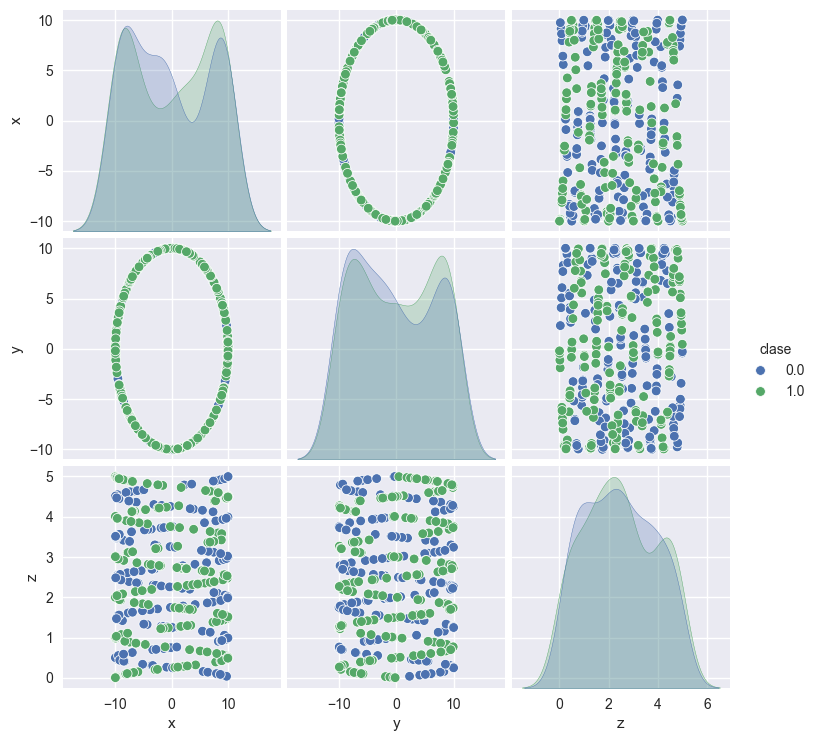

In [ ]:
helices = Dataset("helices", X, y)
df = pd.DataFrame(X, columns=["x", "y", "z"])
df["clase"] = y
sns.pairplot(df, hue="clase")

### El grafico de abajo, pero en 3d?
https://matplotlib.org/stable/gallery/mplot3d/bars3d.html#sphx-glr-gallery-mplot3d-bars3d-py

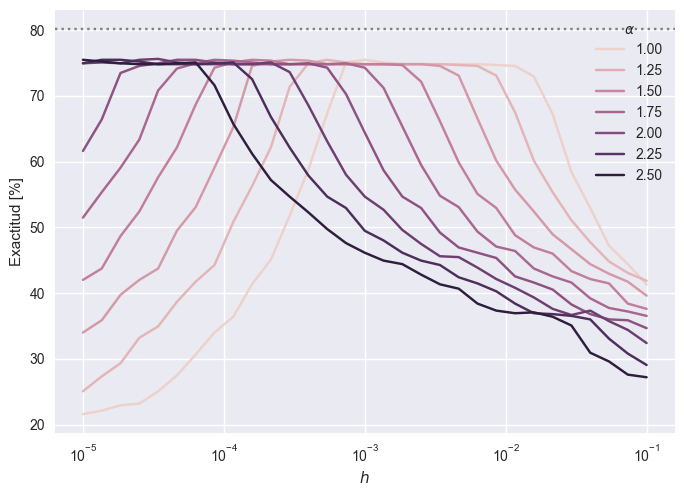

In [ ]:
sns.lineplot(
    data=grilla[grilla.stage == "test"], x="clf__bandwidth", y="score", hue="clf__alpha"
)
plt.xlabel("$h$"), plt.ylabel("Exactitud [%]"), plt.legend(title="$\\alpha$")
plt.axhline(tarea.puntajes.fkdc * 100, linestyle="dotted", color="gray")
plt.xscale("log")

### Sapienza's Swiss Roll
> We use the well-known example coined “Swiss roll”, Figure 1(a) and 1(b). We consider a dataset composed of 4 subsets steaming from independent Normal distributions (restricted to the unit square) with mean $\mu_1 = (.3, .3), \mu_2 = (.3, .7), \mu_3 = (.7, .3), \mu_4 = (.7, .7)$ respectively and constant variance, Figure 1(a). Then, we apply the Swiss Roll transformation, Figure 1(b).

<Axes: xlabel='x', ylabel='y'>

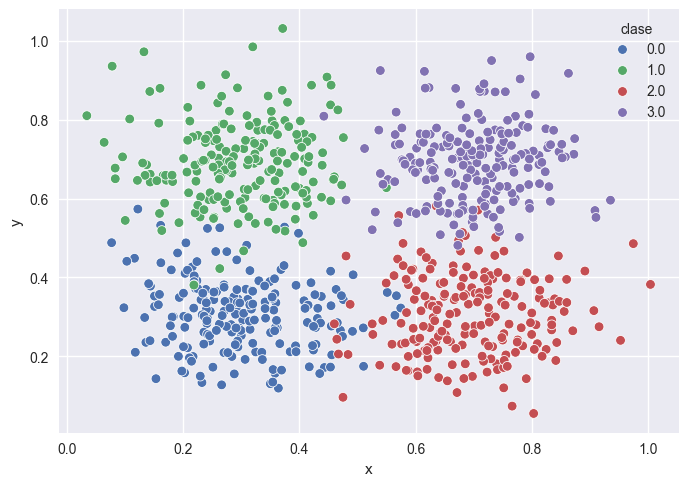

In [ ]:
n_samples = 200
limites = (0.3, 0.7)
centros = [(x, y) for x in limites for y in limites]
varianza = 0.01 * np.identity(len(centros[0]))
Xs = np.vstack(
    [stats.multivariate_normal(mean=c, cov=varianza).rvs(n_samples) for c in centros]
)
ys = np.concatenate([np.ones(n_samples) * i for i in range(len(centros))])
ds = Dataset("swissroll", Xs, ys)
df = pd.DataFrame(Xs, columns=["x", "y"])
df["clase"] = ys.astype(str)
sns.scatterplot(data=df, x="x", y="y", hue="clase")

In [ ]:
def swissroll(x, y, noise=0.005, return_t=False):
    # Versión modificada de https://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch6/lle.py
    N = len(x)

    t = 2 * np.pi * (1 + 2 * x)
    h = 21 * y
    data = np.vstack((t * np.cos(t), h, t * np.sin(t))) + noise * np.random.randn(3, N)
    if return_t:
        return np.transpose(data), np.squeeze(t)
    else:
        return np.transpose(data)

In [ ]:
swissed = pd.DataFrame(swissroll(Xs[:, 0], Xs[:, 1]), columns=["x", "y", "z"])
swissed["clase"] = ys.astype(str)
swissed.sample(10)

,x,y,z,clase
579,-2.481890,5.251821,14.092696,2.0
636,-11.850349,11.364434,9.268832,3.0
426,-9.883703,3.015751,11.106490,2.0
209,-8.465044,11.254329,-5.286610,1.0
85,-1.569489,8.065008,7.900790,0.0
438,-15.718403,2.514799,-0.306587,2.0
622,-13.699413,16.800853,6.689282,3.0
713,-13.750657,17.090183,-8.695828,3.0
414,-2.614936,3.069278,14.078771,2.0
762,1.748279,19.364152,13.905677,3.0


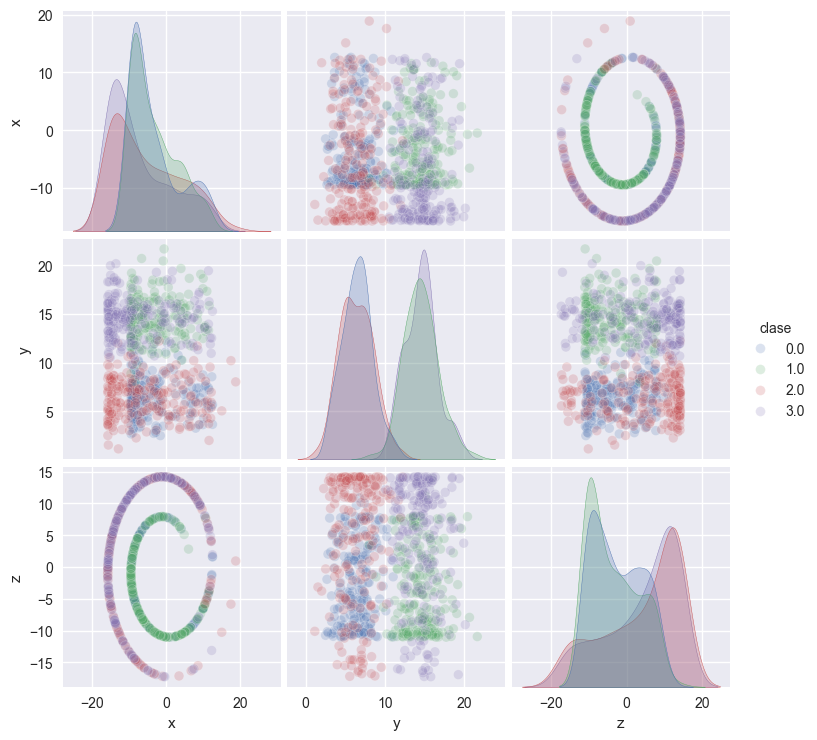

In [ ]:
sns.pairplot(swissed, hue="clase", plot_kws=Bunch(alpha=0.2))